# Analysis of Stack Exchange data lake data 
This jupyter notebook aims to analyze the data lake data that was collected from Stack Exchange. 
The primary goal is to get an overview over the data and to detect possible data quality problems. 

## Overview over time

In [70]:
import pandas as pd
import os
import sqlalchemy

conn_string = f"postgresql://{os.getenv('SE_USER')}:{os.getenv('SE_PASSWORD')}@{os.getenv('SE_ENDPOINT')}/{os.getenv('SE_DATABASENAME')}"
sqlalchemy_connection_se = sqlalchemy.create_engine(conn_string)

questions = pd.read_sql("""SELECT TO_TIMESTAMP(creation_date)::DATE date, COUNT(*) questions FROM questions
                           WHERE creation_date > 1649894400 -- from 14. April 2022 00:00:00
                           GROUP BY TO_TIMESTAMP(creation_date)::DATE
                           ORDER BY TO_TIMESTAMP(creation_date)::DATE;""", sqlalchemy_connection)
answers = pd.read_sql("""SELECT TO_TIMESTAMP(creation_date)::DATE date, COUNT(*) answers FROM answers
                         WHERE creation_date > 1649894400 -- from 14. April 2022 00:00:00
                         GROUP BY TO_TIMESTAMP(creation_date)::DATE
                         ORDER BY TO_TIMESTAMP(creation_date)::DATE;""", sqlalchemy_connection)

time_overview = pd.merge(questions, answers, on='date')
time_overview

,date,questions,answers
0,2022-04-14,3029,2870
1,2022-04-15,2584,2470
2,2022-04-16,1889,1803
3,2022-04-17,1913,1735
4,2022-04-18,2712,2513


<AxesSubplot:xlabel='date'>

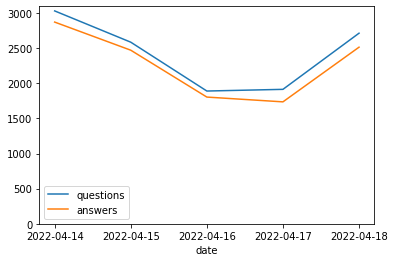

In [41]:
time_overview.plot(x='date', xticks=overview.date, ylim=(0, None))

## Overview of technologies

In [93]:
conn_string = f"postgresql://{os.getenv('DJ_USER')}:{os.getenv('DJ_PASSWORD')}@{os.getenv('DJ_ENDPOINT')}/{os.getenv('DJ_DATABASENAME')}"
sqlalchemy_connection_dj = sqlalchemy.create_engine(conn_string)

share_overview = pd.DataFrame(columns=('technology', 'questions', 'answers'))
technologies = sqlalchemy_connection_dj.execute("SELECT technology FROM top_technologies;")
for technology in technologies: 
    tech_tag = technology[0].lower()
    q_result = pd.read_sql(f"SELECT COUNT(*) FROM questions WHERE tags LIKE '%%{tech_tag}%%';", sqlalchemy_connection_se)
    a_result = pd.read_sql(f"""SELECT COUNT(*) FROM answers a
                               INNER JOIN questions q ON a.question_id = q.question_id
                               WHERE q.tags LIKE '%%{tech_tag}%%';""", sqlalchemy_connection_se)
    share_overview = share_overview.append(pd.DataFrame({'technology': [tech_tag],
                                                         'questions': [q_result.iloc[0, 0]],
                                                         'answers': [a_result.iloc[0, 0]]}))
share_overview

,technology,questions,answers
0,java,5658,4171
0,javascript,3712,2908
0,cloud,420,371
0,docker,438,246
0,azure,375,288
0,python,5464,4235
0,react,2145,1666
0,typescript,627,465
0,angular,526,371
0,c#,1392,959


<AxesSubplot:xlabel='technology'>

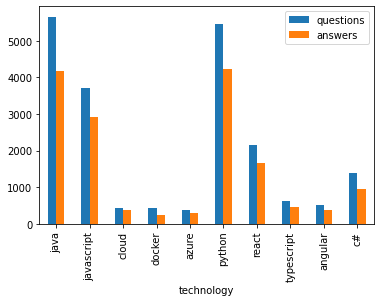

In [95]:
share_overview.plot.bar(x='technology')